In [1]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn        #for all Neural Network stuff
import torch.optim as optim  #for all optimizer stuff

import torchvision
from torchvision import transforms
import tensorflow as tf
from tensorboardX import SummaryWriter
import scipy.misc 
from io import BytesIO  

In [2]:
#method argument not needed??
data_size = 1000 #number of points in linspace
batch_time = 20 #number of points in the interval after a random starting point
batch_size = 500 #number of intervals
niters = 2000 #number of iterations
test_freq = 10
viz = True
gpu = 1
adjoint = True

In [3]:
class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)
        
    """def scalar_summary(self, tag, step):
        Log a scalar variable.
        self.writer.add_summary(tag, step)"""
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [4]:
from torchdiffeq import odeint_adjoint as odeint

In [5]:
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [6]:
#initial conditions; requires 2D tensor
true_y0 = torch.tensor([[2.0,1.0]])
#create linspace like usual
t = torch.linspace(0.0, 25.0, data_size)
#creates a system of differential equations for dy and dx
true_A = torch.tensor([[-0.1,2.0],[-2.0, -0.1]]) # will generate 2 right hand side second order DE's

In [7]:
#lambda is a nn.Module like Linear, Conv2D etc,,
class Lambda(nn.Module):
    def forward(self,t,y):
        return torch.mm(y**3,true_A) #< is the same as below
        #return torch.tensor([-0.1*y[:,0]**3-2*y[:,1]**3,2*y[:,0]**3-0.1*y[:,1]**3])  #starting with true_y0 it does mxn X nxp -> mxp

In [8]:
with torch.no_grad(): #no_grad disables gradient finding when true_y is defined
    #print(torch.mm(true_y0**3,true_A))
    true_y = odeint(Lambda(),true_y0, t, method='adams') 
#true_y is the solved ODE defined in Lambda
#odeint only takes a function from nn.Module >> implications? see solver comparision Jupyter
#it uses Lambda to provide the function to go solve the IVP given true_y0 with the ODE solver on t

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time, dtype=np.int64), batch_size, replace=False))
#s is a torch tensor from a numpy array. the array is a random choice array, a rand number from 0 to ds-bt is chosen bs times.
#s has batch_size elements and each was equally likely to be chosen
#why ds-bt? why not just data_size as a rance since we are chosing from the t linspace with ds many points?
#it does ds-bt so that when it chooses the next bt number of points we will never fall out of the index range if
#    ds=1000 and bt=10 then then if i start at 990, I will end up with 990-1000 and not over.
    batch_y0 = true_y[s] #(M, D) <- idk what this means
#b_y0 is made of the randomly selected data points (dep vals) from true_y solution
    batch_t = t[:batch_time] #(T)
#b_t is the values rank 0 to b_time from your linspace t; the linspace values being looked at
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)],dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


In [10]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [11]:
makedirs('png')

In [12]:
def drawDFT(ySpace, length, function):
    for l in ySpace:
        for k in ySpace:
            y = torch.tensor([[l,k]])
            t = torch.tensor([[]])
            #direction i and j + Magnitude of <i,j>
            i = function.forward(t,y)[:,0][0].numpy()
            j = function.forward(t,y)[:,1][0].numpy()
            magnitude = np.sqrt(i**2+j**2)
            
            #normalize and scale by h
            i = h*i/magnitude
            j = h*j/magnitude
            
            current_domain = np.linspace(l-(i/2), l+(i/2), 2) #the end points of the small intervals
            current_range = np.linspace(k-(j/2), k+(j/2), 2)

            plt.plot(current_domain, current_range, lw=0.2, color='b')
            plt.arrow(current_domain[0],current_range[0], i, j, color='b', lw=0.5, length_includes_head=True, head_length=0.1, head_width=0.1)

In [13]:
def visualize(true_y, pred_y, y_space, length, function):
    b = y_space[y_space.size-1]
    a = y_space[0]
    
    #Draw True Y
    drawDFT(y_space, length, Lambda())
    plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1],'r--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()
    
    #Draw Pred Y
    drawDFT(y_space, length, function)
    plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1],'m--')
    plt.xlim(a,b)
    plt.ylim(a,b)
    plt.savefig('png/{:03d}'.format(itr))
    plt.show()

In [14]:
class ODEFunc(nn.Module): #create an ODE block as our neural network. usually multiple layers/modules
    
    def __init__(self):
        super(ODEFunc, self).__init__()
#self.net is the neural network layers one after the other L -> T -> L        
        self.net = nn.Sequential(    
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m,nn.Linear): #checks in the module m in self.net is an instance of the nn.Linear class
                nn.init.normal_(m.weight, mean=0, std=0.1) #for the Linear modules make all the weights randn with std 0.1
                nn.init.constant_(m.bias, val=0) #for the Linear modules make all the bias vector values 0
    
    def forward(self, t, y):
        return self.net(y**3) #essentially Lambda.forward(args) without the true_A >>>which is TBD<<<

In [15]:
class RunningAverageMeter(object): #Computes and stores the average and current value
    def __init__(self, momentum=0.99): #new object of this class will have mom of 0.99 and a reset val and avg
        self.momentum = momentum
        self.reset()
    def reset(self):                   #reset function called to set val and avg to None and 0 respectively
        self.val = None
        self.avg = 0
    def update(self, val):             #update is called externally to update the avg based on val
        if self.val is None:
            self.avg = val
        else:
            self.avg = (self.avg * self.momentum) + (val * (1 - self.momentum)) #reminds me of output error at L

Iteration 0001 | Total Loss 0.801400
Iteration 0002 | Total Loss 0.620200
Iteration 0003 | Total Loss 0.730226
Iteration 0004 | Total Loss 0.579087
Iteration 0005 | Total Loss 0.601724
Iteration 0006 | Total Loss 0.614620
Iteration 0007 | Total Loss 0.654661
Iteration 0008 | Total Loss 0.625079
Iteration 0009 | Total Loss 0.435792
Iteration 0010 | Total Loss 0.558382


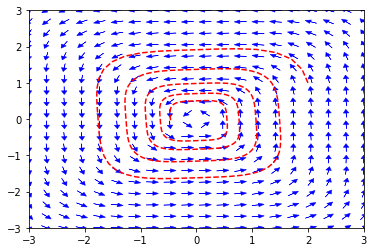

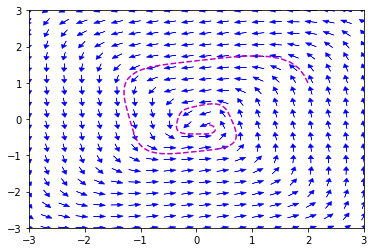

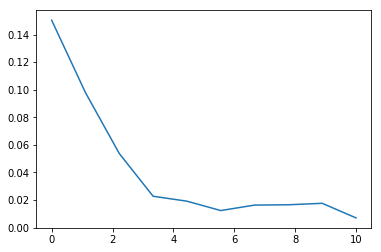

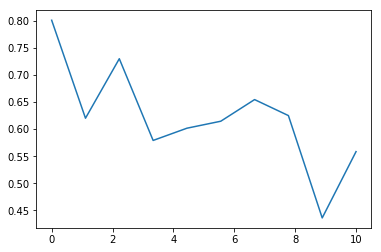

Iteration 0011 | Total Loss 0.829253
Iteration 0012 | Total Loss 0.540924
Iteration 0013 | Total Loss 0.467095
Iteration 0014 | Total Loss 0.549636
Iteration 0015 | Total Loss 0.622047
Iteration 0016 | Total Loss 0.607367
Iteration 0017 | Total Loss 0.230074
Iteration 0018 | Total Loss 0.578560
Iteration 0019 | Total Loss 4.226923
Iteration 0020 | Total Loss 0.541078


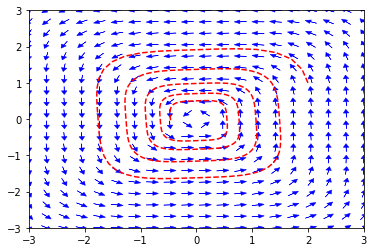

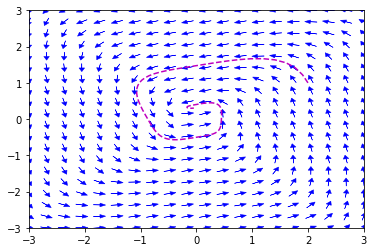

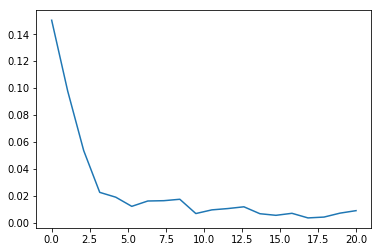

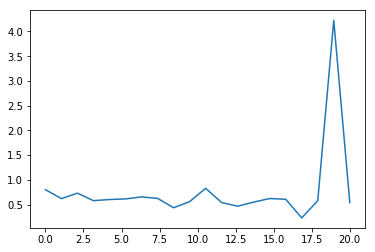

Iteration 0021 | Total Loss 0.544241
Iteration 0022 | Total Loss 0.580948
Iteration 0023 | Total Loss 0.616708
Iteration 0024 | Total Loss 0.664059
Iteration 0025 | Total Loss 0.581922
Iteration 0026 | Total Loss 0.732952
Iteration 0027 | Total Loss 0.625180
Iteration 0028 | Total Loss 0.849525
Iteration 0029 | Total Loss 0.626744
Iteration 0030 | Total Loss 4.327648


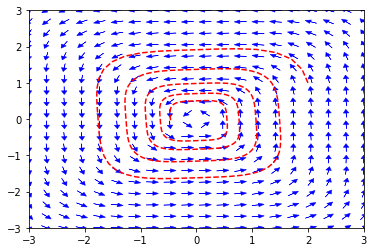

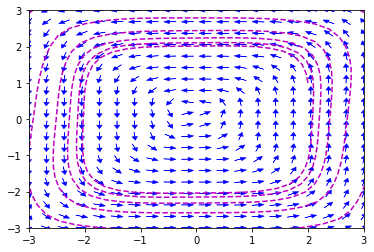

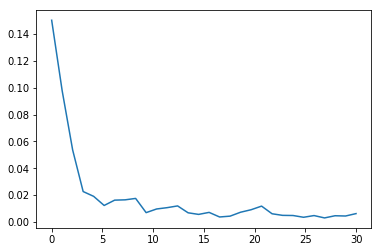

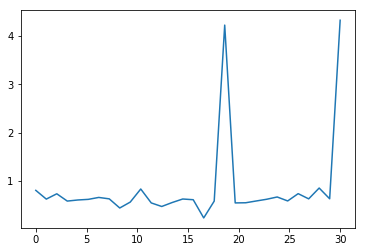

Iteration 0031 | Total Loss 0.561684
Iteration 0032 | Total Loss 0.951591
Iteration 0033 | Total Loss 0.595463
Iteration 0034 | Total Loss 0.677241
Iteration 0035 | Total Loss 0.652773


KeyboardInterrupt: 

In [18]:
if __name__ == '__main__':
    
    #ii = 0
    
    Y = torch.linspace(-3,3,20)
    h = 0.22
    
    func = ODEFunc()
    logger = Logger('./logs')
    
    losses1 = []
    losses2 = []
    
    optimizer = optim.RMSprop(func.parameters())          #this is an optimizer designed to update parameters
    end = time.time()                                     #usually people use SGD but this is a mini-batch approach
                                                          #http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    #RunningAvgMeter Objects
    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)
    
    #TRAINING
    for itr in range(1, niters+1):
        optimizer.zero_grad() #set gradients to zero/ not computed
        batch_y0, batch_t, batch_y = get_batch()
        #feeds odeint the ODEBlock, a set of y values based on random t values and the first ten values of t
        pred_y = odeint(func, batch_y0, batch_t)
        #deviates from usual Loss of mean squared difference but sum in both cases is positive
        loss = torch.mean(torch.abs(pred_y-batch_y)**2) #ask Ivan about predY-bY, also this returns a number
        losses1.append(loss)
        
        loss.backward() #backpropogation
        optimizer.step() #gradient descent and update parameters
    
        #Update time and loss meters
        time_meter.update(time.time()-end) #takes in time difference to establish velocity see RMS method details
        loss_meter.update(loss.item()) #the loss itself is a delta / change
        
        ################################################################## 
        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in func.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), itr+1)
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), itr+1)
        ###########################################################################
        
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y-true_y))
            losses2.append(loss)
            print('Iteration {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
        
            if itr % test_freq == 0:
                visualize(true_y,pred_y, Y.numpy(), h, func)
                u = np.linspace(0,len(losses1),len(losses1))
                plt.plot(u,losses1)
                plt.show()
                w = np.linspace(0,len(losses2),len(losses2))
                plt.plot(w,losses2)
                plt.show()
                
                
        end = time.time()